### Data Preparation for Bayesian Filter

install dependencies....

In [1]:
!pip install beautifulsoup4

In [2]:
!pip install wordcloud

In [3]:
#we are importing all the libraries we would like to use.
#including data stores for stopwords and such
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from math import log, sqrt
import pandas as pd
import numpy as np
import os
import io
%matplotlib inline

### This function reads the files in the specified path.

In [4]:
def read_files(path):
    #this function is reading the actual email files.
    #the function will cycle through all the files in the folder specified.
    for root, dirnames, filenames in os.walk(path):
        for filename in filenames:
            path = os.path.join(root,filename)
            
            inBody = False
            lines = []
            #this uses IO functions to read the files by specifying the encoding type
            f = io.open(path, 'r', encoding = 'latin1')
            #this cycles through each line and fetches the text therein.
            for line in f:
                if inBody:
                    lines.append(line)
                elif line == '\n':
                    inBody = True
            f.close()
            #join the text into a single message.
            message = '\n'.join(lines)
            #return the message
            yield path, message
                    

### This function is for creating dataframes from the dataset in question... it also classifies the emails into either ham or spam

In [5]:
#this classifies the emails into spam or ham depending on predetermined status.
def dataFrameFromDirectory(path, classification):
    #instantiate the structure of the dataframe needed.
    rows = []
    index = []
    #store the message alongside its classification.
    for filename, message in read_files(path):
        rows.append({'message': message, 'label': classification})
        index.append(filename)
        #return the dataframe to be used for manipulation
    return pd.DataFrame(rows, index=index)

aggregate all the emails into a single dataframe. The key is: ham = 0, spam = 1

In [6]:
#fetch the data from the source files.
data = pd.DataFrame({'message':[],'label':[]})
data = data.append(dataFrameFromDirectory("datasets/ham2",0))
data = data.append(dataFrameFromDirectory("datasets/spam2",1))
data

,message,label
datasets/ham2/1663.3cda52dac479d2b668e3410feb916e38,"On Thu, Sep 05, 2002 at 08:53:16PM -0400, Theo...",0.0
datasets/ham2/1664.e67aee25046de6fd0243b8c6fec81c5b,And you were exactly the person I figured woul...,0.0
datasets/ham2/2077.eba992ea7cedb65c1fddbf9ea01484f3,"URL: http://www.newsisfree.com/click/-3,825186...",0.0
datasets/ham2/2525.9559a3f0d4d17d33379acdf5bf356435,URL: http://diveintomark.org/archives/2002/10/...,0.0
datasets/ham2/1757.ade7f371dd3f7c4393baf201b803755a,"\n\n>>>>> ""NS"" == Neil Schemenauer <nas@python...",0.0
...,...,...
datasets/spam2/0150.30c44c205041fd95f00ef524ea54e356,"<HR>\n\n<html>\n\n<div bgcolor=3D""#FFFFCC"">\n\...",1.0
datasets/spam2/0138.eab076de94bd9f1d19908f682e58031f,==============================================...,1.0
datasets/spam2/0295.717c906cda92746007b9098e16c727b2,"<html>\n\n\n\n<head>\n\n<meta http-equiv=3D""Co...",1.0
datasets/spam2/0313.5126f820bf11ba460e2c1611cee632c1,------=_NextPart_000_00E4_17A73C2D.E7104E07\n\...,1.0


The below cell shows the number of rows in our dataframe.

In [7]:
total_mails = data['message'].shape[0]
total_mails

600

The function below extracts all text from html text present in all emails.

In [8]:
#this is for scraping the emails, since most are in the form of html based content.
from bs4 import BeautifulSoup

def func(df):
    soup = BeautifulSoup(df['message'], "html.parser").find()
    #check emails with html syntax
    if bool(soup):
        soup = BeautifulSoup(df['message'], "html.parser")
        #extract text only from the whole email.
    
        text = soup.find_all(text=True)
      
        #return all the words found.
        text = ''.join(word for word in  text)
        df['message'] = text
        
        return text
    else:
        
        return df['message'] 

In [9]:
new_data = data.reset_index()
new_data

,index,message,label
0,datasets/ham2/1663.3cda52dac479d2b668e3410feb9...,"On Thu, Sep 05, 2002 at 08:53:16PM -0400, Theo...",0.0
1,datasets/ham2/1664.e67aee25046de6fd0243b8c6fec...,And you were exactly the person I figured woul...,0.0
2,datasets/ham2/2077.eba992ea7cedb65c1fddbf9ea01...,"URL: http://www.newsisfree.com/click/-3,825186...",0.0
3,datasets/ham2/2525.9559a3f0d4d17d33379acdf5bf3...,URL: http://diveintomark.org/archives/2002/10/...,0.0
4,datasets/ham2/1757.ade7f371dd3f7c4393baf201b80...,"\n\n>>>>> ""NS"" == Neil Schemenauer <nas@python...",0.0
...,...,...,...
595,datasets/spam2/0150.30c44c205041fd95f00ef524ea...,"<HR>\n\n<html>\n\n<div bgcolor=3D""#FFFFCC"">\n\...",1.0
596,datasets/spam2/0138.eab076de94bd9f1d19908f682e...,==============================================...,1.0
597,datasets/spam2/0295.717c906cda92746007b9098e16...,"<html>\n\n\n\n<head>\n\n<meta http-equiv=3D""Co...",1.0
598,datasets/spam2/0313.5126f820bf11ba460e2c1611ce...,------=_NextPart_000_00E4_17A73C2D.E7104E07\n\...,1.0


In [10]:
new_data[new_data['message'].str.isalnum()]

,index,message,label


split the data into the pareto principle for unbiased model testing.
so 80% will be used for training and 20% for testing.
this will be accomplished by using a random number generator to randomize the order by implementing a uniform distribution randomizer. this removes all chances of having a biased model on account of sequential data.

In [11]:
#split the data into training and testing sets
#initializing empty lists to hold training and testing data respectively
train_index, test_index = list(), list()
for i in range(data['message'].shape[0]):
    #make use of the uniform random distribution to alleviate contiguousness of pseudo-random number generators.
    #80% for training and 20% for testing according to the pareto principle.
    if np.random.uniform(0,1) < 0.80:
        train_index.append(i)
    else:
        test_index.append(i)
#training data dataframe.
train_data = new_data.loc[train_index]
#test data dataframe
test_data = new_data.loc[test_index]

implement the data cleaning of the html based messages
    

In [12]:
#here we  apply the scraping function to our data. hence cleaning it.
train_data['message'] = train_data.apply(func, axis=1)
test_data['message'] = test_data.apply(func, axis=1)
train_data

/home/ian/snap/jupyter/common/lib/python3.7/site-packages/bs4/__init__.py:389: UserWarning: "http://www.post-gazette.com/columnists/20020905brian5.asp






" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


,index,message,label
0,datasets/ham2/1663.3cda52dac479d2b668e3410feb9...,"On Thu, Sep 05, 2002 at 08:53:16PM -0400, Theo...",0.0
1,datasets/ham2/1664.e67aee25046de6fd0243b8c6fec...,And you were exactly the person I figured woul...,0.0
2,datasets/ham2/2077.eba992ea7cedb65c1fddbf9ea01...,"URL: http://www.newsisfree.com/click/-3,825186...",0.0
3,datasets/ham2/2525.9559a3f0d4d17d33379acdf5bf3...,URL: http://diveintomark.org/archives/2002/10/...,0.0
4,datasets/ham2/1757.ade7f371dd3f7c4393baf201b80...,"\n\n>>>>> ""NS"" == Neil Schemenauer writes:\n\...",0.0
...,...,...,...
594,datasets/spam2/0373.2171ee7f8e73e1092279077df2...,"WERKEN BIJ DE LOTTO,\n\n41132, NL-1007 DB AMST...",1.0
596,datasets/spam2/0138.eab076de94bd9f1d19908f682e...,==============================================...,1.0
597,datasets/spam2/0295.717c906cda92746007b9098e16...,\n\n\n\n\n\nNorton AD\n\n\n\n\n=\n\nTake\n\n ...,1.0
598,datasets/spam2/0313.5126f820bf11ba460e2c1611ce...,------=_NextPart_000_00E4_17A73C2D.E7104E07\n\...,1.0


In [13]:
import re

train_data['message'] = train_data['message'].map(lambda x: re.sub(r'\W+', ' ', x))
test_data['message'] = test_data['message'].map(lambda x: re.sub(r'\W+', ' ', x))

In [14]:
train_data['message'].str.isalnum()

0      False
1      False
2      False
3      False
4      False
       ...  
594    False
596    False
597    False
598    False
599    False
Name: message, Length: 482, dtype: bool

In [15]:
test_data

,index,message,label
8,datasets/ham2/0667.9e0b1ad2888b8d638be9d486637...,Original Message From Luis Villa They were th...,0.0
20,datasets/ham2/0646.5b8ef44185fab30abb58d0f4408...,From Stephen D Williams mailto swilliams hpti...,0.0
21,datasets/ham2/0071.75403094cab986a246c1e7ce346...,E Eirikur Hallgrimsson writes E Gary s news s...,0.0
23,datasets/ham2/0371.9d01da72c49d57814fa8a37c7b9...,Actually this is common I ve known a couple of...,0.0
30,datasets/ham2/0069.7173de1d2da14306c5a20e8abda...,Once upon a time Joshua wrote Just a thought w...,0.0
...,...,...,...
579,datasets/spam2/0145.ec89d85ec20f9aeda6fe37c0b6...,Do You Want To Teach and Grow Rich If you are...,1.0
586,datasets/spam2/0108.4506c2ef846b80b9a7beb90315...,Digital Publishing Tools Free Software Alert ...,1.0
587,datasets/spam2/0186.e739e1c9fdc0702762d3583b26...,Norton AD Take Control of Your Computer With ...,1.0
593,datasets/spam2/0446.d971f234fa00ed94e18f5ce8f5...,This is a multi part message in MIME format _N...,1.0


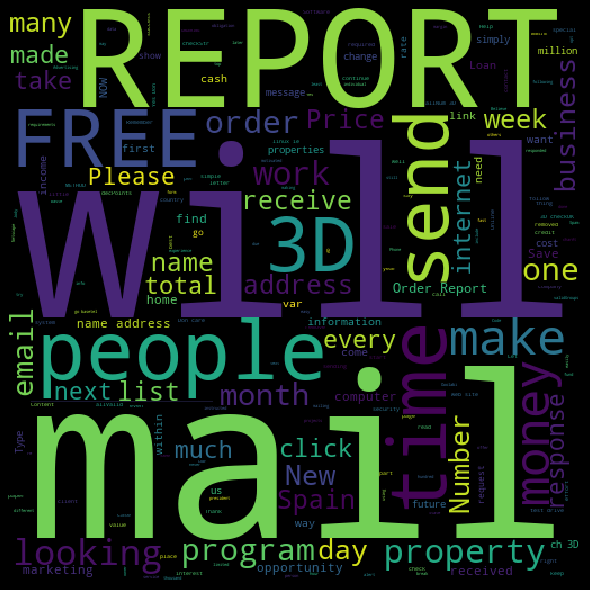

In [24]:
#visual representation of the most salient words.
#this is the visulization for the spam.
spam_words = ' '.join(str(moja) for moja in list(test_data[test_data['label'] == 1]['message']))
spamwc = WordCloud(width = 512, height=512).generate(spam_words)
plt.figure(figsize=(10,8), facecolor='k')
plt.imshow(spamwc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

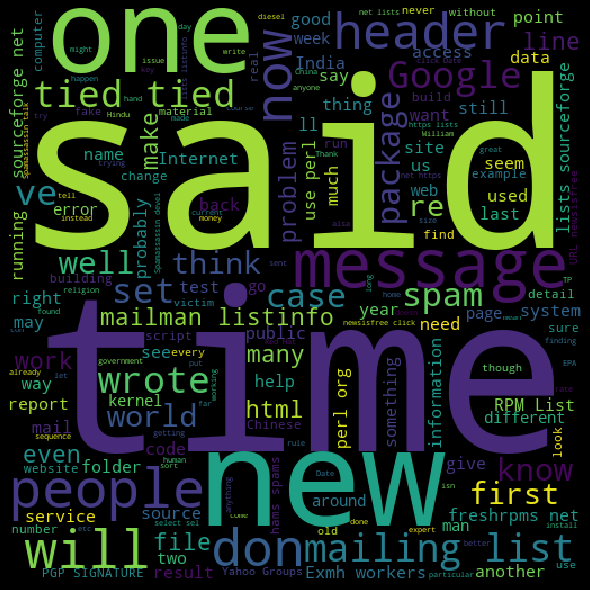

In [25]:
#Visualize the ham data
spam_words = ' '.join(str(moja) for moja in list(test_data[test_data['label'] == 0]['message']))
spamwc = WordCloud(width = 512, height=512).generate(spam_words)
plt.figure(figsize=(10,8), facecolor='k')
plt.imshow(spamwc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

distribution by value

In [18]:
train_data['label'].value_counts()

0.0    399
1.0     83
Name: label, dtype: int64

in this cell we preprocess the text to be able to be fit into the model.
the first step is to first make all the text lower case for uniformity.
Then we tokenize each message in the dataset.
Tokenization  is the task of splitting up a message into pieces and throwing away the punctuation characters.
The words like ‘go’, ‘goes’, ‘going’ indicate the same activity. We can replace all these words by a single word ‘go’. This is called stemming. We are going to use Porter Stemmer, which is a famous stemming algorithm.

In [19]:
#tokenizing and processing the words harnessed.
def process_message(message, lower_case = True, stem = True, stop_words = True, gram = 2):
    #lower case letters
    if lower_case:
        message = message.lower()
    words = word_tokenize(message)
    words = [w for w in words if len(w) > 2]
#     print(words)
    if gram > 1:
        w = []
        for i in range(len(words) - gram + 1):
            w += [' '.join(words[i:i + gram])]
        return w
    if stop_words:
        sw = stopwords.words('english')
        words = [word for word in words if word not in sw]
    if stem:
        stemmer = PorterStemmer()
        words = [stemmer.stem(word) for word in words]   
#     print(words)
    return words

In [20]:
train_data.columns

Index(['index', 'message', 'label'], dtype='object')

In [21]:
class SpamClassifier(object):
    def __init__(self, train_data, method = 'tf-idf'):
        self.mails, self.labels = train_data['message'], train_data['label']
        self.method = method

    def train(self):
        self.calc_TF_and_IDF()
        if self.method == 'tf-idf':
            self.calc_TF_IDF()
        else:
            self.calc_prob()

    def calc_prob(self):
        self.prob_spam = dict()
        self.prob_ham = dict()
        for word in self.tf_spam:
            self.prob_spam[word] = (self.tf_spam[word] + 1) / (self.spam_words + \
                                                                len(list(self.tf_spam.keys())))
        for word in self.tf_ham:
            self.prob_ham[word] = (self.tf_ham[word] + 1) / (self.ham_words + \
                                                                len(list(self.tf_ham.keys())))
        self.prob_spam_mail, self.prob_ham_mail = self.spam_mails / self.total_mails, self.ham_mails / self.total_mails 


    def calc_TF_and_IDF(self):
        noOfMessages = self.mails.shape[0]
        self.spam_mails, self.ham_mails = self.labels.value_counts()[1], self.labels.value_counts()[0]
        self.total_mails = self.spam_mails + self.ham_mails
        self.spam_words = 0
        self.ham_words = 0
        self.tf_spam = dict()
        self.tf_ham = dict()
        self.idf_spam = dict()
        self.idf_ham = dict()
        self.missing_index = [number for number in range(0,noOfMessages) if number not in self.mails.index ]
        for i in range(noOfMessages):
            if i not in self.missing_index:
                message_processed = process_message(self.mails[i])
                count = list() #To keep track of whether the word has ocured in the message or not.
                               #For IDF
                for word in message_processed:
                    if self.labels[i]:
                        self.tf_spam[word] = self.tf_spam.get(word, 0) + 1
                        self.spam_words += 1
                    else:
                        self.tf_ham[word] = self.tf_ham.get(word, 0) + 1
                        self.ham_words += 1
                    if word not in count:
                        count += [word]
                for word in count:
                    if self.labels[i]:
                        self.idf_spam[word] = self.idf_spam.get(word, 0) + 1
                    else:
                        self.idf_ham[word] = self.idf_ham.get(word, 0) + 1

    def calc_TF_IDF(self):
        self.prob_spam = dict()
        self.prob_ham = dict()
        self.sum_tf_idf_spam = 0
        self.sum_tf_idf_ham = 0
        for word in self.tf_spam:
            self.prob_spam[word] = (self.tf_spam[word]) * log((self.spam_mails + self.ham_mails) \
                                                          / (self.idf_spam[word] + self.idf_ham.get(word, 0)))
            self.sum_tf_idf_spam += self.prob_spam[word]
        for word in self.tf_spam:
            self.prob_spam[word] = (self.prob_spam[word] + 1) / (self.sum_tf_idf_spam + len(list(self.prob_spam.keys())))
            
        for word in self.tf_ham:
            self.prob_ham[word] = (self.tf_ham[word]) * log((self.spam_mails + self.ham_mails) \
                                                          / (self.idf_spam.get(word, 0) + self.idf_ham[word]))
            self.sum_tf_idf_ham += self.prob_ham[word]
        for word in self.tf_ham:
            self.prob_ham[word] = (self.prob_ham[word] + 1) / (self.sum_tf_idf_ham + len(list(self.prob_ham.keys())))
            
    
        self.prob_spam_mail, self.prob_ham_mail = self.spam_mails / self.total_mails, self.ham_mails / self.total_mails 
                    
    def classify(self, processed_message):
        pSpam, pHam = 0, 0
        for word in processed_message:                
            if word in self.prob_spam:
                pSpam += log(self.prob_spam[word])
            else:
                if self.method == 'tf-idf':
                    pSpam -= log(self.sum_tf_idf_spam + len(list(self.prob_spam.keys())))
                else:
                    pSpam -= log(self.spam_words + len(list(self.prob_spam.keys())))
            if word in self.prob_ham:
                pHam += log(self.prob_ham[word])
            else:
                if self.method == 'tf-idf':
                    pHam -= log(self.sum_tf_idf_ham + len(list(self.prob_ham.keys()))) 
                else:
                    pHam -= log(self.ham_words + len(list(self.prob_ham.keys())))
            pSpam += log(self.prob_spam_mail)
            pHam += log(self.prob_ham_mail)
        return pSpam >= pHam
    
    def predict(self, testData):
        result = dict()
        for (i, message) in enumerate(testData):
            processed_message = process_message(message)
            print(processed_message)
            result[i] = int(self.classify(processed_message))
        return result

In [22]:
def metrics(labels, predictions):
    true_pos, true_neg, false_pos, false_neg = 0, 0, 0, 0
    for i in range(len(labels)):
        true_pos += int(labels[i] == 1 and predictions[i] == 1)
        true_neg += int(labels[i] == 0 and predictions[i] == 0)
        false_pos += int(labels[i] == 0 and predictions[i] == 1)
        false_neg += int(labels[i] == 1 and predictions[i] == 0)
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    Fscore = 2 * precision * recall / (precision + recall)
    accuracy = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)

    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F-score: ", Fscore)
    print("Accuracy: ", accuracy)

In [23]:
sc_bow = SpamClassifier(train_data, 'bow')
sc_bow.train()
preds_bow = sc_bow.predict(test_data['message'])
metrics(test_data['label'], preds_bow)

['original message', 'message from', 'from luis', 'luis villa', 'villa they', 'they were', 'were the', 'the ruling', 'ruling class', 'class feudal', 'feudal farming', 'farming society', 'society for', 'for quite', 'quite some', 'some time', 'time believe', 'believe there', 'there were', 'were more', 'more than', 'than few', 'few issues', 'issues there', 'there certainly', 'certainly not', 'not everyone', 'everyone tibet', 'tibet excited', 'excited about', 'about the', 'the dalai', 'dalai lama', 'lama hollywood', 'hollywood appears', 'appears not', 'not that', 'that the', 'the chinese', 'chinese are', 'are much', 'much better', 'better rights', 'rights wise', 'wise but', 'but they', 'they actually', 'actually built', 'built roads', 'roads and', 'and such', 'such which', 'which led', 'led the', 'the creation', 'creation merchant', 'merchant classes', 'classes and', 'and the', 'the like', 'like that', 'that never', 'never existed', 'existed under', 'under the', 'the tibetans', 'tibetans a

ValueError: math domain error

In [ ]:
sc_tf_idf = SpamClassifier(train_data, 'tf-idf')
sc_tf_idf.train()
preds_tf_idf = sc_tf_idf.predict(test_data['message'])
metrics(testData['label'], preds_tf_idf)


In [ ]:
pm = process_message('I cant pick the phone right now. Pls send a message')
sc_tf_idf.classify(pm)

In [ ]:
pm = process_message('Congratulations ur awarded $500 ')
sc_tf_idf.classify(pm)

In [ ]:
train_data.reset_index(drop=True)

In [ ]:
-